In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from glob import glob
import pandas as pd
import pickle
import random
from PIL import Image
from glob import glob
import re
#from adjustText import adjust_text
import seaborn as sns
import statannot
import argparse
#import torch
import wandb
import sys
sys.path.append('./modified_medsam_repo')

In [3]:
def read_tag_from_wandb(tag, project_name, min_epoch_cutoff = 4):
    # read yolov7 runs
    api = wandb.Api()
    
    # Project is specified by <entity/project-name>
    runs = api.runs(path =f"nair-karthik00/{project_name}", filters = {'tags': tag})
    #runs.append(api.run('nair-karthik00/MedSAM_finetune_hcp_ya_second_round_with_bbox/a935xpc7'))

    summary_list, config_list, name_list = [], [], []
    id_seen = {}
    for run in runs:
        name = run.name
        #if not re.match(pattern, name):
        #    continue
        if run.id in id_seen.keys(): # sometimes wandb passes in the same run twice, so safeguard against this
            continue
        else:
            id_seen[run.id] = True
        
        
        # .summary contains the output keys/values for metrics like accuracy.
        #  We call ._json_dict to omit large files
        dicto = run.summary._json_dict
        if 'val_dice_scores/class_Unknown' not in dicto.keys() or dicto['epoch'] < min_epoch_cutoff: # this run is not finished yet
            print('skip ' + name.split('_')[0].split('label')[1])
            continue
        summary_list.append(dicto)

        # .config contains the hyperparameters.
        #  We remove special values that start with _.
        config_list.append(
            {k: v for k,v in run.config.items()
            if not k.startswith('_')})

        # .name is the human-readable name of the run.
        name_list.append(run.name)


    runs_df = pd.DataFrame({
        "summary": summary_list,
        "config": config_list,
        "name": name_list
        })
    
    runs_df['label'] = [int(x.split('_')[0].split('label')[1]) for x in runs_df['name']]
    runs_df['val_dice_score'] = [x['val_dice_scores/class_Unknown']['max'] for x in runs_df['summary']]
    runs_df['num_samples_per_epoch'] = [x['num_training_samples'] / (x['epoch']+1) for x in runs_df['summary']]
    runs_df['num_samples_per_epoch'] = runs_df['num_samples_per_epoch'].astype(int)
    runs_df = runs_df.sort_values('label').reset_index(drop=True)
    ret_df = runs_df[['label', 'val_dice_score', 'num_samples_per_epoch']]

    #assert ret_df.shape[0] == 102
    assert ret_df['label'].value_counts().max() == 1
    
    return ret_df

In [36]:
#multitask, no prompt
#multitask_unprompt = pd.DataFrame(multitask_unprompt)
#multitask_unprompt = multitask_unprompt.iloc[1:, :].reset_index(names='label_number')

In [18]:
def proc_pattern_for_eval_result_load(pattern):
    files = glob(pattern)
    listo = []
    for file in files:
        label_num = int(file.split('/')[-1].split('label')[1].split('.pkl')[0])
        
        stuff = pd.read_pickle(file)
        this_list = [label_num, stuff['dice_sensitivity'].item(), stuff['dice_specificity'].item(), stuff['overall_dice'].item()]
        this_arr = np.array(this_list).reshape((1, 4))
        listo.append(this_arr)

        

    combined = np.concatenate(listo, axis = 0)
    df = pd.DataFrame(combined, columns = ['label_number', 'dice_sensitivity', 'dice_specificity', 'overall_dice'])
    df = df.sort_values('label_number').reset_index(drop=True)

    return df

#yolov7 = proc_pattern_for_eval_result_load('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/eval_results_val_8-26-23/eval_singletask_yolov7_prompted_val_label*.pkl')
#yolov7_longer = proc_pattern_for_eval_result_load('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/eval_results_val_8-26-23/eval_singletask_yolov7_longer_prompted_val_label*.pkl')

#pooled
'''
listo = []
for node in range(8):
    xx = pd.read_pickle(f'/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/eval_results_val_8-26-23/eval_pooltask_yolov7_prompted_val_label1_node{node}.pkl')
    for k in xx.keys():
        xx[k] = xx[k].flatten()
    dfo = pd.DataFrame.from_dict(xx)
    listo.append(dfo)
pooled = pd.concat(listo)
pooled = pooled.rename(mapper = {'label_numbers':'label_number'}, axis = 'columns')
pooled = pooled.groupby('label_number').agg({'dice_sensitivity':'mean', 'dice_specificity':'mean', 'overall_dice':'mean'}).reset_index()

# multitask no prompt
multitask_unprompt = pd.read_pickle('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/eval_results_test_10-13-23/eval_multitask_unprompted_test_label1.pkl')
multitask_unprompt['label_numbers'] = list(range(0,103))
multitask_unprompt = pd.DataFrame(multitask_unprompt).loc[1:, :].reset_index(drop=True)

#multitask
multitask = pd.read_pickle('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/eval_results_val_8-26-23/eval_multitask_unprompted_val_label1.pkl')
multitask = pd.DataFrame(multitask)
multitask = multitask.iloc[1:, :].reset_index(names='label_number')

#yolov7 pooled 3D
dices_3d = np.load('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/eval_3D_pooled_labels_9-4-23/val_dices.npy')
dices_3d = dices_3d[1:].tolist()
label_numbers = list(range(1,103))
pooled_3d = pd.DataFrame({'label_number': label_numbers, 'dice_sensitivity': dices_3d})

# singletask no boxes
constant_bbox_finetune_df = read_tag_from_wandb(tag = 'constant_bbox', project_name = 'MedSAM_finetune_hcp_ya_second_round_with_bbox')
'''



# singletask unet
singletask_unet = pd.read_pickle('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/unet_retrain_all_labels_9-9-24/val/combined_val.pkl')
singletask_unet = pd.DataFrame(singletask_unet)
singletask_unet = singletask_unet.rename({'label_numbers': 'label_number'}, axis=1)
singletask_unet = singletask_unet.reset_index(drop=True)
#singletask_unet = multitask.iloc[1:, :].reset_index(names='label_number')

# singletask medsam
singletask_medsam = pd.read_pickle('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/medsam_retrain_9-12-24/val/combined_val.pkl')
singletask_medsam = pd.DataFrame(singletask_medsam)
singletask_medsam = singletask_medsam.rename({'label_numbers': 'label_number'}, axis=1)

# singletask sam
singletask_sam = pd.read_pickle('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/singletask_SAM_training_all_labels_10-18-24/val/combined_val.pkl')
singletask_sam = pd.DataFrame(singletask_sam)
singletask_sam = singletask_sam.rename({'label_numbers': 'label_number'}, axis=1)

# singletask medsam with yolo prompting
singletask_medsam_yolo = pd.read_pickle('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/singletask_medsam_with_yolo_main_10-14-24/val/combined_val_INCOMPLETE.pkl')
singletask_medsam_yolo = pd.DataFrame(singletask_medsam_yolo)
singletask_medsam_yolo = singletask_medsam_yolo.rename({'label_numbers': 'label_number'}, axis=1)

# fill in missing labels ^
dicto = {'dice_sensitivity':[0.0, 0.0, 0.0, 0.0], 'dice_specificity':[1.0, 1.0, 1.0, 1.0], 'overall_dice':[np.nan, np.nan, np.nan, np.nan], 'label_number': [3,18,22,33]}
append_df = pd.DataFrame(dicto)
singletask_medsam_yolo = pd.concat([singletask_medsam_yolo, append_df], ignore_index=True)

# singletask medsam with yolo prompting without training (this is broken)
singletask_medsam_yolo_untrained = pd.read_pickle('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/singletask_untrained_medsam_yolo_10-22-24/val/combined_val.pkl')
singletask_medsam_yolo_untrained = pd.DataFrame(singletask_medsam_yolo_untrained)
singletask_medsam_yolo_untrained = singletask_medsam_yolo_untrained.rename({'label_numbers': 'label_number'}, axis=1)



In [24]:
singletask_medsam_yolo.shape

(102, 4)

In [25]:
#print(multitask_unprompt['dice_sensitivity'].median())
'''
print(multitask['dice_sensitivity'].median()) # this is an unprompted multitask
print(singletask_medsam_yolo['dice_sensitivity'].median())
print(yolov7_longer['dice_sensitivity'].median())
print(pooled['dice_sensitivity'].median())
print(pooled_3d['dice_sensitivity'].median())
'''
print(singletask_unet['dice_sensitivity'].median())
print(singletask_medsam['dice_sensitivity'].median())
print(singletask_sam['dice_sensitivity'].median())
print(singletask_medsam_yolo['dice_sensitivity'].median())
print(singletask_medsam_yolo_untrained['dice_sensitivity'].median())

0.7539893686771393
0.6484129130840302
0.5799015462398529
0.6248834133148193
2.1958019402745776e-08


In [26]:
'''
df_merged = multitask[['label_number', 'dice_sensitivity']].merge(yolov7[['label_number', 'dice_sensitivity']], 
                on='label_number', suffixes = ['_multitask', '_yolov7'], how='inner')

df_merged2 = yolov7_longer[['label_number', 'dice_sensitivity']].merge(pooled[['label_number', 'dice_sensitivity']], 
                on='label_number', suffixes = ['_yolov7_longer', '_pooled'], how='inner')
df_merged = df_merged.merge(df_merged2, on='label_number', how = 'inner')

pooled_3d = pooled_3d.rename(mapper = {'dice_sensitivity':'dice_sensitivity_pooled_3d'}, axis = 'columns')
df_merged = df_merged.merge(pooled_3d, on='label_number', how = 'inner')

df_merged3 = singletask_unet[['label_number', 'dice_sensitivity']].merge(singletask_medsam[['label_number', 'dice_sensitivity']],
                on='label_number', suffixes = ['_singletask_unet', '_singletask_medsam'], how='inner')
df_merged = df_merged.merge(df_merged3, on='label_number', how = 'inner')

'''

df_merged = singletask_unet[['label_number', 'dice_sensitivity']].merge(singletask_medsam[['label_number', 'dice_sensitivity']],
    on = 'label_number', suffixes = ['_singletask_unet', '_singletask_medsam'], how='inner')
df_merged = df_merged.merge(singletask_medsam_yolo[['label_number', 'dice_sensitivity']], on = 'label_number', how='inner')
df_merged = df_merged.rename({'dice_sensitivity': 'dice_sensitivity_singletask_medsam_yolo', 
                            'dice_specificity': 'dice_specificity_singletask_medsam_yolo',
                            'overall_dice': 'overall_dice_singletask_medsam_yolo'}, axis=1)

df_merged = df_merged.merge(singletask_sam[['label_number', 'dice_sensitivity']], on = 'label_number', how='inner')
df_merged = df_merged.rename({'dice_sensitivity': 'dice_sensitivity_singletask_sam', 
                            'dice_specificity': 'dice_specificity_singletask_sam',
                            'overall_dice': 'overall_dice_singletask_sam'}, axis=1)

df_merged

,label_number,dice_sensitivity_singletask_unet,dice_sensitivity_singletask_medsam,dice_sensitivity_singletask_medsam_yolo,dice_sensitivity_singletask_sam
0,1,0.942036,0.872116,0.869885,0.870347
1,2,0.900616,0.832562,0.815303,0.753467
2,3,0.749551,0.538952,0.000000,0.436768
3,4,0.735495,0.608625,0.603218,0.594019
4,5,0.893992,0.852614,0.834910,0.842884
...,...,...,...,...,...
97,98,0.774828,0.682675,0.624025,0.648325
98,99,0.779624,0.698922,0.661897,0.672823
99,100,0.776131,0.677491,0.633860,0.647924
100,101,0.705914,0.600911,0.553299,0.408181


In [27]:
'''
merged_long = pd.melt(df_merged, id_vars = ['label_number'], 
                    value_vars = ['dice_sensitivity_multitask', 'dice_sensitivity_yolov7', 'dice_sensitivity_yolov7_longer', 
                    'dice_sensitivity_pooled', 'dice_sensitivity_pooled_3d', 'dice_sensitivity_singletask_unet', 'dice_sensitivity_singletask_medsam'],
                    var_name = 'method', value_name = 'val_dice_score'
)
'''
merged_long = pd.melt(df_merged, id_vars = ['label_number'], 
                    value_vars = ['dice_sensitivity_singletask_unet', 'dice_sensitivity_singletask_medsam', 'dice_sensitivity_singletask_medsam_yolo', 'dice_sensitivity_singletask_sam'],
                    var_name = 'method', value_name = 'val_dice_score'
)
mapper = {'dice_sensitivity_pooled': 'pooled', 'dice_sensitivity_yolov7': 'yolov7',
          'dice_sensitivity_multitask': 'multitask', 'dice_sensitivity_yolov7_longer': 'yolov7_longer',
          'dice_sensitivity_pooled_3d': 'pooled_3D', 
          'dice_sensitivity_singletask_unet': 'singletask_unet',
          'dice_sensitivity_singletask_medsam': 'singletask_medsam',
          'dice_sensitivity_singletask_medsam_yolo': 'singletask_medsam_yolo',
          'dice_sensitivity_singletask_sam': 'singletask_sam'}
merged_long['method'] = merged_long['method'].map(mapper)

merged_long

,label_number,method,val_dice_score
0,1,singletask_unet,0.942036
1,2,singletask_unet,0.900616
2,3,singletask_unet,0.749551
3,4,singletask_unet,0.735495
4,5,singletask_unet,0.893992
...,...,...,...
403,98,singletask_sam,0.648325
404,99,singletask_sam,0.672823
405,100,singletask_sam,0.647924
406,101,singletask_sam,0.408181


## Run everything above this each time

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

singletask_medsam v.s. multitask: t-test paired samples with Bonferroni correction, P_val=1.474e-05 stat=4.833e+00
multitask v.s. yolov7: t-test paired samples with Bonferroni correction, P_val=3.471e-07 stat=-5.716e+00
yolov7 v.s. yolov7_longer: t-test paired samples with Bonferroni correction, P_val=3.187e-08 stat=-6.245e+00


(<Axes: xlabel='Method', ylabel='Val Dice Score'>,
  <statannot.StatResult.StatResult at 0x1554668c5d20>])

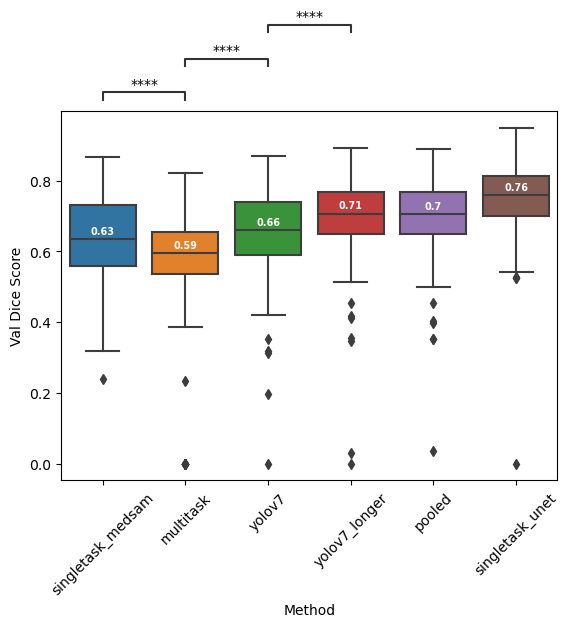

In [7]:
# is there significant difference in how well these methods perform?

order = ['singletask_medsam', 'multitask', 'yolov7', 'yolov7_longer', 'pooled', 'singletask_unet']
box_plot = sns.boxplot(data = merged_long,
            x = 'method',
            y = 'val_dice_score',
            order = order
)
plt.xticks(rotation=45)

plt.ylabel('Val Dice Score')
plt.xlabel('Method')

medians = merged_long.groupby('method')['val_dice_score'].median().reindex(index = order)
vertical_offset = .02 * merged_long['val_dice_score'].median()

for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians[xtick] + vertical_offset,f'%s' % float('%.2g' % medians[xtick]), 
            horizontalalignment='center',size='x-small',color='w',weight='semibold')

statannot.add_stat_annotation(
    plt.gca(),
    data=merged_long,
    x='method',
    y='val_dice_score',
    order = order,
    box_pairs=[
        (order[0], order[1]),
        (order[1], order[2]),
        (order[2], order[3])
    ],
    test="t-test_paired",
    text_format="star",
    loc="outside",
)


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

multitask v.s. singletask_medsam: t-test paired samples with Bonferroni correction, P_val=9.557e-06 stat=-5.003e+00
singletask_medsam v.s. yolov7: t-test paired samples with Bonferroni correction, P_val=1.270e-01 stat=-2.178e+00
yolov7 v.s. yolov7_longer: t-test paired samples with Bonferroni correction, P_val=1.810e-08 stat=-6.418e+00
yolov7_longer v.s. pooled: t-test paired samples with Bonferroni correction, P_val=1.000e+00 stat=-2.419e-01


(<Axes: xlabel='Method', ylabel='Val Dice Score'>,
  <statannot.StatResult.StatResult at 0x15545ff42350>])

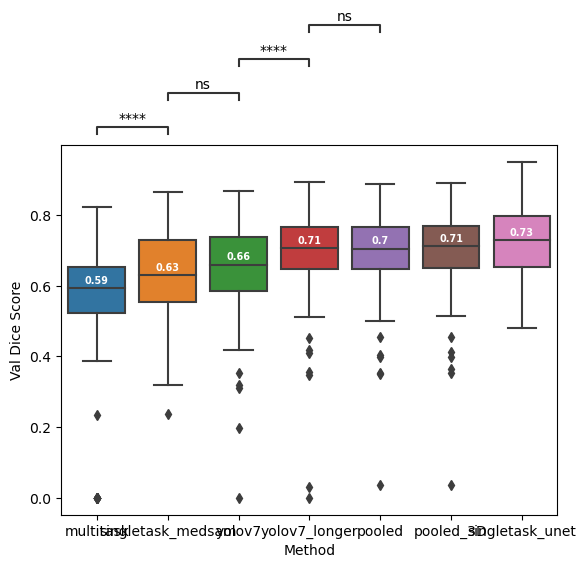

In [39]:
# including pooled 3d
# is there significant difference in how well these methods perform?

order = ['multitask', 'singletask_medsam', 'yolov7', 'yolov7_longer', 'pooled', 'pooled_3D', 'singletask_unet']
box_plot = sns.boxplot(data = merged_long,
            x = 'method',
            y = 'val_dice_score',
            order = order
)

plt.ylabel('Val Dice Score')
plt.xlabel('Method')

medians = merged_long.groupby('method')['val_dice_score'].median().reindex(index = order)
vertical_offset = .02 * merged_long['val_dice_score'].median()

for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians[xtick] + vertical_offset,f'%s' % float('%.2g' % medians[xtick]), 
            horizontalalignment='center',size='x-small',color='w',weight='semibold')

statannot.add_stat_annotation(
    plt.gca(),
    data=merged_long,
    x='method',
    y='val_dice_score',
    order = order,
    box_pairs=[
        (order[0], order[1]),
        (order[1], order[2]),
        (order[2], order[3]),
        (order[3], order[4])
    ],
    test="t-test_paired",
    text_format="star",
    loc="outside",
)


### 3D-pooled model performance

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

pooled v.s. pooled_3D: t-test paired samples with Bonferroni correction, P_val=4.255e-15 stat=-9.239e+00


(<Axes: xlabel='Method', ylabel='Val Dice Score'>,
 [<statannot.StatResult.StatResult at 0x2aab9e10ff70>])

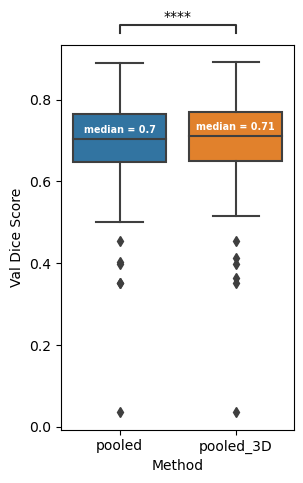

In [34]:
# pooled vs pooled-3D
# is there significant difference in how well these methods perform?

plt.figure(figsize=(3,5))
order = ['pooled', 'pooled_3D']
subset_df = merged_long[merged_long['method'].isin(order)].reset_index(drop=True)
box_plot = sns.boxplot(data = subset_df,
            x = 'method',
            y = 'val_dice_score',
            order = order
)

plt.ylabel('Val Dice Score')
plt.xlabel('Method')

medians = subset_df.groupby('method')['val_dice_score'].median().reindex(index = order)
vertical_offset = .02 * subset_df['val_dice_score'].median()

for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians[xtick] + vertical_offset,f'median = %s' % float('%.2g' % medians[xtick]), 
            horizontalalignment='center',size='x-small',color='w',weight='semibold')

statannot.add_stat_annotation(
    plt.gca(),
    data=subset_df,
    x='method',
    y='val_dice_score',
    order = order,
    box_pairs=[
        (order[0], order[1])
    ],
    test="t-test_paired",
    text_format="star",
    loc="outside",
)


In [50]:
df_merged

,label_number,dice_sensitivity_multitask,dice_sensitivity_yolov7,dice_sensitivity_yolov7_longer,dice_sensitivity_pooled,dice_sensitivity_pooled_3d
0,1,7.994661e-01,0.862020,0.885881,0.883167,0.886895
1,2,7.696944e-01,0.811639,0.835924,0.820664,0.822044
2,3,1.349329e-07,0.311646,0.354801,0.351988,0.363103
3,4,5.743010e-01,0.599371,0.687716,0.677760,0.686748
4,5,7.807698e-01,0.849339,0.860170,0.854176,0.854875
...,...,...,...,...,...,...
97,98,5.675806e-01,0.667417,0.715483,0.713493,0.723542
98,99,6.003175e-01,0.678250,0.738180,0.729847,0.741977
99,100,5.792221e-01,0.685869,0.722563,0.719753,0.726841
100,101,5.373104e-01,0.594538,0.650480,0.645915,0.657094


Text(9.444444444444445, 0.5, 'Dice Score (Pooled 3D)')

<Figure size 500x500 with 0 Axes>

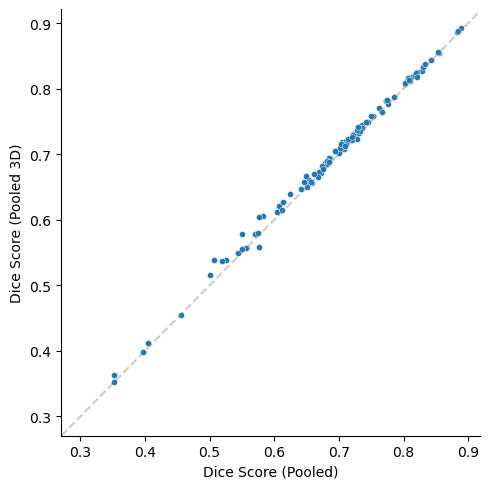

In [54]:
df_merged_tmp = df_merged[df_merged.dice_sensitivity_pooled > 0.2].reset_index(drop=True)
plt.figure(figsize=(5,5))
sns.relplot(df_merged_tmp, x = 'dice_sensitivity_pooled', y = 'dice_sensitivity_pooled_3d', s=20)
plt.axline((.3, .3), slope=1, linestyle = '--', color = 'gray', alpha = .4)
plt.xlabel('Dice Score (Pooled)')
plt.ylabel('Dice Score (Pooled 3D)')

### Main Comparison between main methods

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

MedSAM + YOLO v.s. MedSAM: t-test paired samples with Bonferroni correction, P_val=7.612e-08 stat=-6.044e+00
MedSAM v.s. UNet: t-test paired samples with Bonferroni correction, P_val=2.984e-26 stat=-1.465e+01
SAM v.s. MedSAM: t-test paired samples with Bonferroni correction, P_val=8.435e-26 stat=-1.443e+01


(<Axes: xlabel='Method', ylabel='Val Dice Score'>,
  <statannot.StatResult.StatResult at 0x155512451810>])

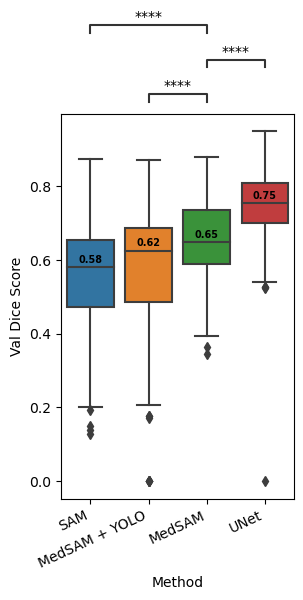

In [52]:
tmpo = merged_long.copy()
mapper = {'singletask_sam': 'SAM', 'singletask_medsam_yolo': 'MedSAM + YOLO', 'singletask_medsam': 'MedSAM', 'singletask_unet': 'UNet'}
tmpo['method'] = [mapper[x] for x in tmpo['method']]
# singletask medsam vs unet

plt.figure(figsize=(3,5))
#order = ['singletask_sam', 'singletask_medsam_yolo', 'singletask_medsam', 'singletask_unet']
order = ['SAM', 'MedSAM + YOLO', 'MedSAM', 'UNet']
subset_df = tmpo[tmpo['method'].isin(order)].reset_index(drop=True)
box_plot = sns.boxplot(data = subset_df,
            x = 'method',
            y = 'val_dice_score',
            order = order
)

plt.ylabel('Val Dice Score')
plt.xlabel('Method')

medians = subset_df.groupby('method')['val_dice_score'].median().reindex(index = order)
vertical_offset = .02 * subset_df['val_dice_score'].median()

for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians[xtick] + vertical_offset,f'%s' % float('%.2g' % medians[xtick]), 
            horizontalalignment='center',size='x-small',color='black',weight='semibold')
for label_txt in box_plot.get_xticklabels():
    label_txt.set_rotation(25)  
    label_txt.set_ha('right')

statannot.add_stat_annotation(
    plt.gca(),
    data=subset_df,
    x='method',
    y='val_dice_score',
    order = order,
    box_pairs=[
        ('SAM', 'MedSAM'),
        ('MedSAM', 'MedSAM + YOLO'),
        ('MedSAM', 'UNet')
    ],
    test="t-test_paired",
    text_format='star',
    loc="outside",
)


### Singletask medsam vs unet

In [59]:
#dfo = pd.DataFrame(constant_bbox_finetune_df['val_dice_score'].tolist(), singletask_unet['dice_sensitivity_singletask_unet'].tolist())
dfo = pd.merge(singletask_medsam, singletask_unet, on='label_number',
    suffixes = ['_singletask_medsam', '_singletask_unet'], )
dfo

,dice_sensitivity_singletask_medsam,dice_specificity_singletask_medsam,overall_dice_singletask_medsam,label_number,dice_sensitivity_singletask_unet,dice_specificity_singletask_unet,overall_dice_singletask_unet
0,0.872116,0.971678,0.929889,1,0.942036,0.997877,0.974439
1,0.832562,0.997422,0.978839,2,0.900616,0.995360,0.984680
2,0.538952,0.983253,0.959096,3,0.749551,0.977894,0.965479
3,0.608625,0.995551,0.930015,4,0.735495,0.993772,0.950026
4,0.852614,0.988681,0.956264,5,0.893992,0.994133,0.970275
...,...,...,...,...,...,...,...
97,0.682675,0.965452,0.902450,98,0.774828,0.989722,0.941844
98,0.698922,0.978378,0.920423,99,0.779624,0.980553,0.938884
99,0.677491,0.984657,0.933938,100,0.776131,0.985879,0.951246
100,0.600911,0.993571,0.968449,101,0.705914,0.990563,0.972352


In [64]:
dfo[['label_number', 'dice_sensitivity_singletask_unet']][:20]

,label_number,dice_sensitivity_singletask_unet
0,1,9.420358e-01
1,2,9.006162e-01
2,3,7.495512e-01
3,4,7.354952e-01
4,5,8.939921e-01
5,6,8.414829e-01
6,7,8.723681e-01
7,8,8.419945e-01
8,9,5.263451e-01
9,10,8.347115e-01


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

singletask_medsam v.s. singletask_unet: t-test paired samples with Bonferroni correction, P_val=9.948e-27 stat=-1.465e+01


(<Axes: xlabel='Method', ylabel='Val Dice Score'>,
 [<statannot.StatResult.StatResult at 0x15551222a890>])

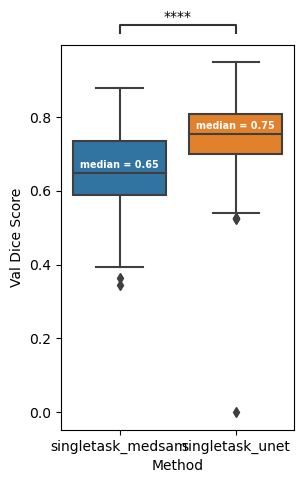

In [56]:
# singletask medsam vs unet

plt.figure(figsize=(3,5))
order = ['singletask_medsam', 'singletask_unet']
subset_df = merged_long[merged_long['method'].isin(order)].reset_index(drop=True)
box_plot = sns.boxplot(data = subset_df,
            x = 'method',
            y = 'val_dice_score',
            order = order
)

plt.ylabel('Val Dice Score')
plt.xlabel('Method')

medians = subset_df.groupby('method')['val_dice_score'].median().reindex(index = order)
vertical_offset = .02 * subset_df['val_dice_score'].median()

for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians[xtick] + vertical_offset,f'median = %s' % float('%.2g' % medians[xtick]), 
            horizontalalignment='center',size='x-small',color='w',weight='semibold')

statannot.add_stat_annotation(
    plt.gca(),
    data=subset_df,
    x='method',
    y='val_dice_score',
    order = order,
    box_pairs=[
        (order[0], order[1])
    ],
    test="t-test_paired",
    text_format='star',
    loc="outside",
)


In [68]:
pd.read_pickle('/gpfs/data/luilab/karthik/pediatric_seg_proj/train_val_test_split.pickle')['val']

[151425,
 214221,
 453441,
 146735,
 147737,
 555954,
 214524,
 134324,
 531536,
 173435,
 196952,
 193239,
 197449,
 249947,
 116524,
 138837,
 211720,
 626648,
 598568,
 304727,
 911849,
 513736,
 943862,
 111312,
 193845,
 729557,
 111009,
 922854,
 227533,
 168745,
 112819,
 108121,
 137229,
 704238,
 199352,
 463040,
 123723,
 615744,
 387959,
 329440,
 176037,
 142424,
 114217,
 106016,
 835657,
 135730,
 115320,
 581349,
 111514,
 128329,
 281135,
 994273,
 220721,
 599671,
 172938,
 173536,
 825553,
 154532,
 160830,
 870861,
 919966,
 200614,
 852455,
 102109,
 212419,
 429040,
 175035,
 820745,
 112516,
 969476,
 297655,
 627852,
 120010,
 518746,
 145632,
 185038,
 199251,
 165840,
 611938,
 395251,
 555348,
 123824,
 342129,
 161731,
 136631,
 158136,
 432332,
 189349,
 144226,
 379657,
 680957,
 300618,
 680452,
 613538,
 623137,
 209228,
 529549,
 151526,
 137431,
 205119,
 121416,
 107321,
 151829,
 668361,
 588565,
 199453,
 130720,
 148840,
 415837,
 151930,
 763557]

Text(9.444444444444445, 0.5, 'Dice Score (UNet)')

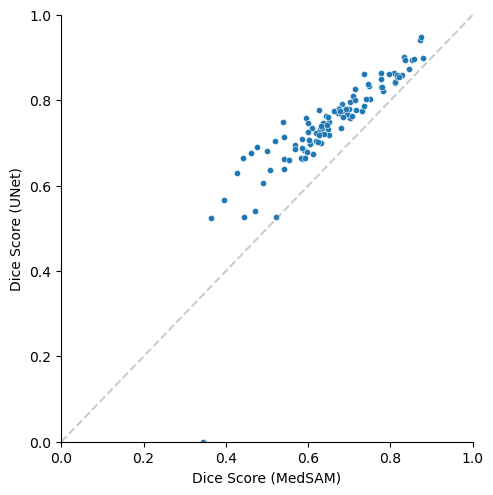

In [66]:
myplot = sns.relplot(dfo, x = 'dice_sensitivity_singletask_medsam', y = 'dice_sensitivity_singletask_unet', s=20)
plt.xlim(0,1)
plt.ylim(0,1)
plt.axline((.3, .3), slope=1, linestyle = '--', color = 'gray', alpha = .4)
plt.xlabel('Dice Score (MedSAM)')
plt.ylabel('Dice Score (UNet)')

### Singletask medsam vs singletask medsam yolo


In [30]:
dfo = pd.merge(singletask_medsam, singletask_medsam_yolo, on='label_number',
    suffixes = ['_singletask_medsam', '_singletask_medsam_yolo'], )
dfo

,dice_sensitivity_singletask_medsam,dice_specificity_singletask_medsam,overall_dice_singletask_medsam,label_number,dice_sensitivity_singletask_medsam_yolo,dice_specificity_singletask_medsam_yolo,overall_dice_singletask_medsam_yolo
0,0.872116,0.971678,0.929889,1,0.869885,0.998726,0.944648
1,0.832562,0.997422,0.978839,2,0.815303,0.999088,0.978372
2,0.608625,0.995551,0.930015,4,0.603218,0.997839,0.931000
3,0.852614,0.988681,0.956264,5,0.834910,0.998291,0.959366
4,0.810882,0.998483,0.980665,6,0.711026,0.999883,0.972447
...,...,...,...,...,...,...,...
93,0.682675,0.965452,0.902450,98,0.624025,0.994521,0.911976
94,0.698922,0.978378,0.920423,99,0.661897,0.993340,0.924605
95,0.677491,0.984657,0.933938,100,0.633860,0.996417,0.936552
96,0.600911,0.993571,0.968449,101,0.553299,0.997932,0.969485


In [ ]:
sns.relplot(dfo, x = 'dice_sensitivity_singletask_medsam', y = 'dice_sensitivity_singletask_medsam_yolo', s=20)
plt.xlim(0,1)
plt.ylim(0,1)
plt.axline((.3, .3), slope=1, linestyle = '--', color = 'gray', alpha = .4)
plt.xlabel('Dice Score (MedSAM)')
plt.ylabel('Dice Score (MedSAM+Yolo)')

In [ ]:
# What factors may explain why certain regions are better predicted by UNet vs MedSAM?
# possibilities: number of positive pixels, number of slices with at least one pixel, 

### Comparing learning rates of singletask unet on validation data

In [5]:
# lr 3.2e-5
singletask_unet_med = pd.read_pickle('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/unet_eval_results_val_7-13-24/combined_val.pkl')
singletask_unet_med = pd.DataFrame(singletask_unet_med)

# lr 1e-4
singletask_unet_high = pd.read_pickle('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/unet_eval_results_lr1e-4_val_7-30-24/combined_val.pkl')
singletask_unet_high = pd.DataFrame(singletask_unet_high)

# lr 1e-5
singletask_unet_low = pd.read_pickle('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/unet_eval_results_lr1e-5_val_7-30-24/combined_val.pkl')
singletask_unet_low = pd.DataFrame(singletask_unet_low)

print(singletask_unet_med['dice_sensitivity'].median())
print(singletask_unet_med['dice_specificity'].median())
print(singletask_unet_med['dice_specificity'].min())

print(singletask_unet_high['dice_sensitivity'].median())
print(singletask_unet_high['dice_specificity'].median())
print(singletask_unet_med['dice_specificity'].min())

print(singletask_unet_low['dice_sensitivity'].median())
print(singletask_unet_low['dice_specificity'].median())
print(singletask_unet_med['dice_specificity'].min())

0.7089871764183044
0.9891116321086884
0.3603794276714325
0.7299074828624725
0.9889152348041534
0.3603794276714325
0.6627864241600037
0.9873768985271454
0.3603794276714325


### MedSAM and UNet subsets performances on val data

In [17]:
pct_list = [0.1, 0.5, 1, 2.5, 5, 10, 25, 50, 75, 100]
label = 1
for pct in pct_list:
    unet_path = f'/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/subset_experiments_singletask_unet_eval_val_8-26-24/{pct}/{label}/eval_singletask_unet_val_label{label}.pkl'
    medsam_path = f'/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/subset_experiments_singletask_medsam_eval_val_8-26-24/{pct}/{label}/eval_singletask_unprompted_val_label{label}.pkl'

    print(f'{pct}: {pd.read_pickle(medsam_path)}')

0.1: {'dice_sensitivity': tensor([0.7617]), 'dice_specificity': tensor([0.8359]), 'overall_dice': tensor([0.8047]), 'label_numbers': []}
0.5: {'dice_sensitivity': tensor([0.7705]), 'dice_specificity': tensor([0.8786]), 'overall_dice': tensor([0.8333]), 'label_numbers': []}
1: {'dice_sensitivity': tensor([0.8168]), 'dice_specificity': tensor([0.8475]), 'overall_dice': tensor([0.8346]), 'label_numbers': []}
2.5: {'dice_sensitivity': tensor([0.8399]), 'dice_specificity': tensor([0.9703]), 'overall_dice': tensor([0.9156]), 'label_numbers': []}
5: {'dice_sensitivity': tensor([0.8513]), 'dice_specificity': tensor([0.9917]), 'overall_dice': tensor([0.9328]), 'label_numbers': []}
10: {'dice_sensitivity': tensor([0.8670]), 'dice_specificity': tensor([0.9954]), 'overall_dice': tensor([0.9415]), 'label_numbers': []}
25: {'dice_sensitivity': tensor([0.8777]), 'dice_specificity': tensor([0.9944]), 'overall_dice': tensor([0.9454]), 'label_numbers': []}
50: {'dice_sensitivity': tensor([0.8842]), 'dic